<a href="https://colab.research.google.com/github/NILEG/TensorFlow/blob/main/Sunspot_CNN_RNN_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [3]:
tf.keras.utils.get_file(origin="https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv", cache_dir="./")

70827/70827 [==============================] - 0s 2us/step


'./datasets/Sunspots.csv'

In [4]:
time_stamps=[]
sun_spots=[]
with open("datasets/Sunspots.csv") as file:
  data=csv.reader(file)
  next(data)#Skip the header row
  for row in data:
    time_stamps.append(int(row[0]))
    sun_spots.append(float(row[2]))
time_stamps=np.array(time_stamps)
sun_spots=np.array(sun_spots)

In [5]:
time_stamps.shape

(3235,)

In [6]:
window_size=60
buffer=1000
batch=64
split_ratio=2500

train_time=time_stamps[:split_ratio]
test_time=time_stamps[split_ratio:]

x_train=sun_spots[:split_ratio]
x_valid=sun_spots[split_ratio:]


In [7]:
def windowed(series, window_size, buffer, batch):
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(window_size+1,shift=1, drop_remainder=True)
  dataset=dataset.flat_map(lambda window:window.batch(window_size+1))
  dataset=dataset.map(lambda window:(window[:-1], window[-1]))
  datset=dataset.shuffle(buffer)
  dataset=dataset.batch(batch).prefetch(1)
  return dataset

In [8]:
dataset=windowed(x_train, window_size, buffer, batch)

In [9]:
def model_return():
  model=tf.keras.Sequential([
      tf.keras.layers.Input(shape=(window_size, 1)),
      tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="relu"),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64)),
      tf.keras.layers.Dense(units=32, activation="relu"),
      tf.keras.layers.Dense(units=16, activation="relu"),
      tf.keras.layers.Dense(units=1),
      tf.keras.layers.Lambda(lambda x: x*400)
  ])
  return model

In [10]:
lr_scheduler=tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-8 * 10**(epoch / 20))
initial_model=model_return()
initial_model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam())
history=initial_model.fit(dataset, epochs=100, callbacks=[lr_scheduler], verbose=1)

Epoch 1/100
39/39 [==============================] - 30s 42ms/step - loss: 92.2801 - lr: 1.0000e-08
Epoch 2/100
39/39 [==============================] - 1s 24ms/step - loss: 92.2082 - lr: 1.1220e-08
Epoch 3/100
39/39 [==============================] - 1s 25ms/step - loss: 92.1301 - lr: 1.2589e-08
Epoch 4/100
39/39 [==============================] - 1s 23ms/step - loss: 92.0416 - lr: 1.4125e-08
Epoch 5/100
39/39 [==============================] - 1s 25ms/step - loss: 91.9411 - lr: 1.5849e-08
Epoch 6/100
39/39 [==============================] - 1s 24ms/step - loss: 91.8281 - lr: 1.7783e-08
Epoch 7/100
39/39 [==============================] - 1s 34ms/step - loss: 91.7027 - lr: 1.9953e-08
Epoch 8/100
39/39 [==============================] - 1s 22ms/step - loss: 91.5632 - lr: 2.2387e-08
Epoch 9/100
39/39 [==============================] - 1s 24ms/step - loss: 91.4070 - lr: 2.5119e-08
Epoch 10/100
39/39 [==============================] - 1s 23ms/step - loss: 91.2323 - lr: 2.8184e-08
Epoch 11

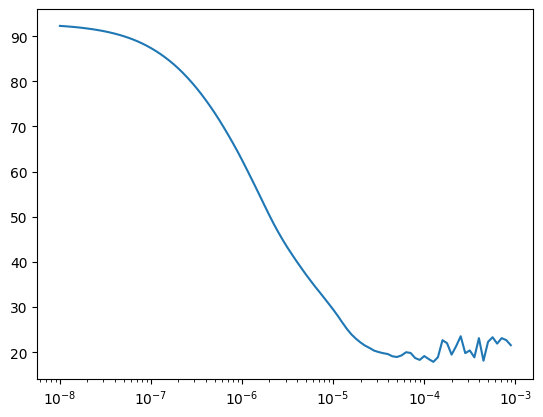

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])

In [13]:
tf.keras.backend.clear_session()
fine_model=model_return()
fine_model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=["mae"])
history=fine_model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
39/39 [==============================] - 9s 23ms/step - loss: 46.5379 - mae: 47.0342
Epoch 2/100
39/39 [==============================] - 1s 25ms/step - loss: 33.3851 - mae: 33.8805
Epoch 3/100
39/39 [==============================] - 1s 25ms/step - loss: 29.8880 - mae: 30.3841
Epoch 4/100
39/39 [==============================] - 2s 43ms/step - loss: 28.1654 - mae: 28.6612
Epoch 5/100
39/39 [==============================] - 1s 24ms/step - loss: 26.9003 - mae: 27.3968
Epoch 6/100
39/39 [==============================] - 1s 25ms/step - loss: 25.8731 - mae: 26.3676
Epoch 7/100
39/39 [==============================] - 2s 41ms/step - loss: 24.9729 - mae: 25.4672
Epoch 8/100
39/39 [==============================] - 1s 25ms/step - loss: 24.1588 - mae: 24.6529
Epoch 9/100
39/39 [==============================] - 1s 25ms/step - loss: 23.4475 - mae: 23.9410
Epoch 10/100
39/39 [==============================] - 1s 24ms/step - loss: 22.8373 - mae: 23.3298
Epoch 11/100
39/39 [=========

In [17]:
def forecast(series, window_size, batch):
  dataset=tf.data.Dataset.from_tensor_slices(series)
  dataset=dataset.window(window_size, shift=1, drop_remainder=True)
  dataset=dataset.flat_map(lambda window: window.batch(window_size))
  dataset=dataset.batch(batch).prefetch(1)
  return dataset

In [18]:
prediction=fine_model.predict(forecast(sun_spots[split_ratio-window_size: -1], window_size, batch))

12/12 [==============================] - 2s 27ms/step


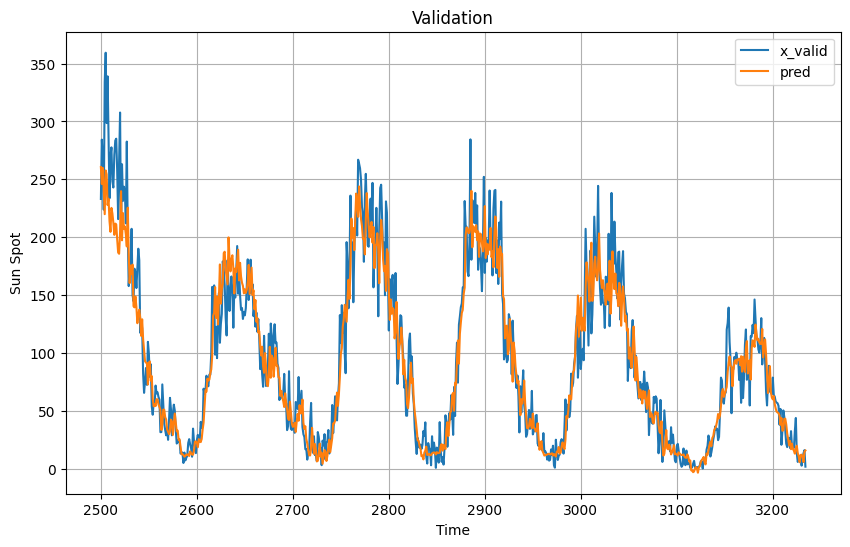

In [23]:
plot_series(test_time, (x_valid, prediction.squeeze()), format="-", start=0, end=None,
                title="Validation", xlabel="Time", ylabel="Sun Spot", legend=["x_valid", "pred"])

In [24]:
tf.keras.metrics.mean_absolute_error(x_valid, prediction.squeeze()).numpy()

17.90687